In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

#### Loading the dataset

In [2]:
raisins_df = pd.read_excel('../datasets/feature_engg/Raisin Dataset.xlsx')

#### Initial data checking

In [3]:
raisins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [4]:
raisins_df['Class'].value_counts()

Class
Kecimen    450
Besni      450
Name: count, dtype: int64

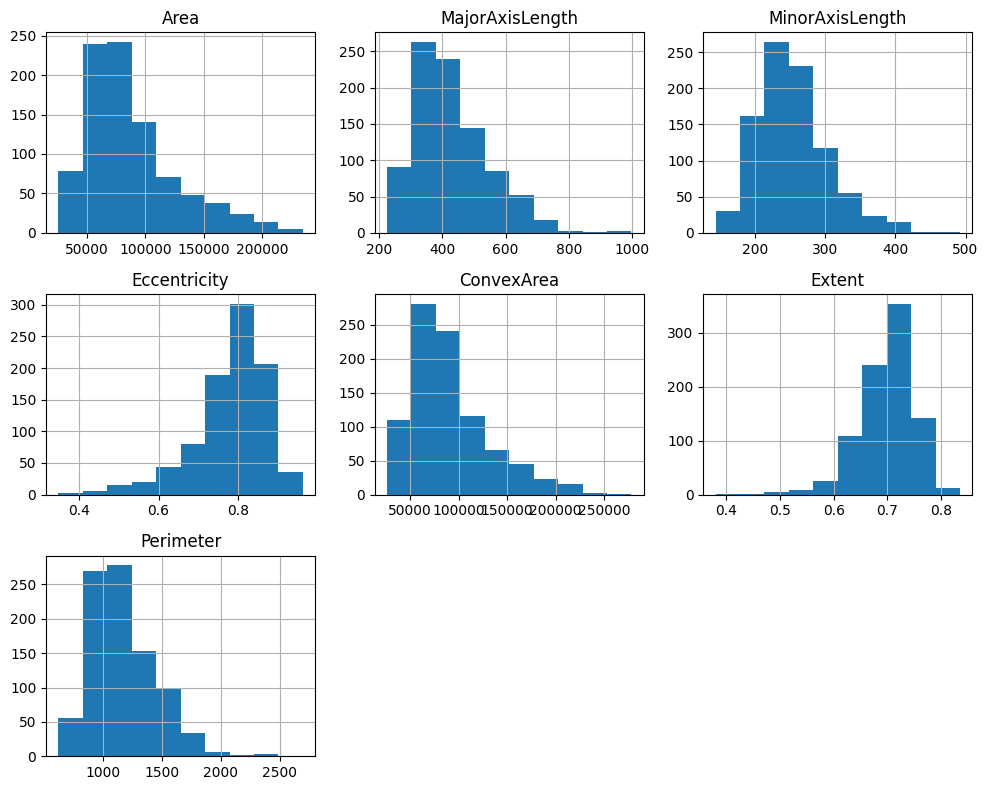

In [5]:
raisins_df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

### Identify the categorical and numeric columns in the dataset

In [6]:
# Identify numeric columns
numeric_columns = raisins_df.select_dtypes(include=['number']).columns.tolist()

# Identify categorical columns
categorical_columns = raisins_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric Columns:", numeric_columns)
print("Categorical Columns:", categorical_columns)


Numeric Columns: ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']
Categorical Columns: ['Class']


### Perform One-Hot Encoding, Ordinal Encoding and Label Encoding on the required columns

In [7]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

raisins_numeric_df = raisins_df.copy()

# Fit and transform the 'Gender' column
raisins_numeric_df['Class'] = label_encoder.fit_transform(raisins_df['Class'])

In [8]:
X = raisins_numeric_df.iloc[:, :7]
y = raisins_numeric_df.loc[:, 'Class']

### Identify the outliers from the given columns using statistical methods (IQR, z-score)

In [9]:
import numpy as np

# Create an empty DataFrame to store outliers
outliers_df = pd.DataFrame()

# Iterate over each feature
for feature in X.columns:
    # Calculate IQR for the current feature
    Q1 = X[feature].quantile(0.25)
    Q3 = X[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Identify outliers using IQR for the current feature
    outliers_iqr = (X[feature] < (Q1 - 1.5 * IQR)) | (X[feature] > (Q3 + 1.5 * IQR))
    
    # Calculate Z-score for the current feature
    z_scores = np.abs((X[feature] - X[feature].mean()) / X[feature].std())
    
    # Identify outliers using Z-score for the current feature
    outliers_zscore = z_scores > 3  # Threshold Z-score of 3
    
    # Combine results for the current feature
    outliers_feature_iqr = outliers_iqr
    outliers_feature_z = outliers_zscore
    
    # Add outliers for the current feature to the outliers DataFrame
    print(f"Outliers for {feature}")
    print("using IQR")
    print(X.loc[outliers_feature_iqr, feature].dropna(axis = 0))
    print("using Z score")
    print(X.loc[outliers_feature_z, feature].dropna(axis = 0))
    print('\n')


Outliers for Area
using IQR
85     180898
467    184784
469    195383
475    177264
479    189637
487    210923
506    182160
507    208264
515    188651
516    202118
522    177206
541    193032
552    204864
560    178334
574    193558
580    206720
581    205497
590    177916
616    199015
622    193818
650    194864
657    192815
666    178692
668    206689
671    182823
678    182788
708    222915
711    204226
751    182122
768    175247
769    195281
771    175946
777    181926
804    223075
812    235047
836    181126
855    189069
866    225043
870    179668
880    218459
893    187391
Name: Area, dtype: int64
using Z score
487    210923
507    208264
552    204864
580    206720
581    205497
668    206689
708    222915
804    223075
812    235047
866    225043
880    218459
Name: Area, dtype: int64


Outliers for MajorAxisLength
using IQR
85     843.956653
290    722.853917
467    740.108710
469    755.012914
487    984.045491
506    997.291941
509    719.505878
540    730.76

### Explore sklearn’s module for outlier detection (eg. LOF, OneClassSVM)

#### LOF of single feature

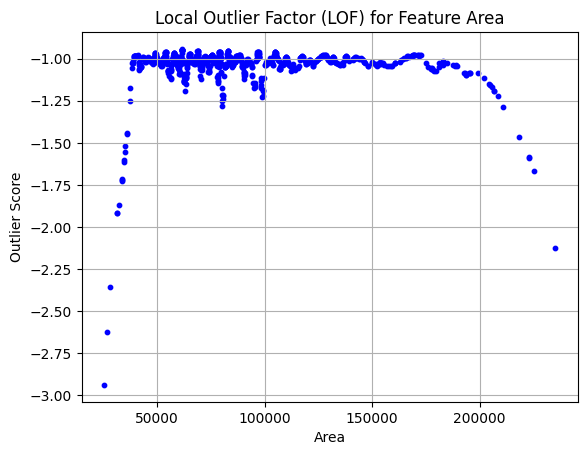

In [10]:
# Select the feature index you want to plot
feature_index = 0  # Change this to the desired feature index

# Extract the selected feature from the dataset X
X_single_feature = X.iloc[:, feature_index].values.reshape(-1, 1)  # Convert to NumPy array and reshape

# Fit the Local Outlier Factor model using only the single feature
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(X_single_feature)
X_scores = lof.negative_outlier_factor_

# Plot the outlier scores
plt.scatter(X_single_feature, X_scores, color='b', s=10)
plt.xlabel(X.columns[feature_index])
plt.ylabel('Outlier Score')
plt.title('Local Outlier Factor (LOF) for Feature ' + X.columns[feature_index])
plt.grid(True)
plt.show()

##### Findings
<li> LocalOutlierFactor from sklearn return the negative LOFs of the data points, that it why the Outlier scores are in negative</li>
<li> If the Outlier score are closer to 1, it means they are not outliers </li>
<li> If the Outlier scores are greater than or lesser than 1, it means those datapoints are outliers </li>
<li> LOF score is the ratio of Local Reachability Density of its neighbors with the Local Reachability Density of that point </li>
<li> In this case for "Area", values greater than 200000 and values lesser than 48000 can be considered as outliers </li>

##### LOF for double features

In [11]:
# Fit the model: Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(X)
X_scores = lof.negative_outlier_factor_

# Choose two features for visualization (let's say feature 0 and feature 1)
feature1_index = 2  # Change this to select the desired feature
feature2_index = 3  # Change this to select the desired feature

if feature1_index >6 2 or feature2_index  
# Plot the data points
plt.scatter(X.iloc[:, feature1_index], X.iloc[:, feature2_index], color="k", s=3.0, label="Data points")

# Plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X.iloc[:, feature1_index],
    X.iloc[:, feature2_index],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)

# Customize legend marker size
def update_legend_marker_size(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([20])

# Set axis limits and labels
plt.axis("tight")
plt.xlabel(X.columns[feature1_index])
plt.ylabel(X.columns[feature2_index])
plt.title("Local Outlier Factor (LOF)")

# Add legend with custom marker size
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)

plt.show()


SyntaxError: invalid syntax (2497197344.py, line 10)

### Perform scaling using (Min-max Scaler/StandardScaler) on the required columns


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define the columns you want to scale
columns_to_scale = list(X.columns)

# Create copies of the DataFrame containing only the required columns
data_to_scale = X[columns_to_scale].copy()

# Perform scaling using Min-Max Scaler
minmax_scaler = MinMaxScaler()
scaled_data_minmax = minmax_scaler.fit_transform(data_to_scale)

# Perform scaling using StandardScaler
standard_scaler = StandardScaler()
scaled_data_standard = standard_scaler.fit_transform(data_to_scale)

# Convert scaled data back to DataFrame
scaled_df_minmax = pd.DataFrame(scaled_data_minmax, columns=columns_to_scale)
scaled_df_standard = pd.DataFrame(scaled_data_standard, columns=columns_to_scale)

# Display scaled DataFrames
print("Scaled data using Min-Max Scaler:")
print(scaled_df_minmax.head())

print("\nScaled data using StandardScaler:")
print(scaled_df_standard.head())


#### Test LOF with scaled data

In [ ]:
# Fit the model: Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(scaled_df_minmax)
X_scores = lof.negative_outlier_factor_

# Choose two features for visualization (let's say feature 0 and feature 1)
feature1_index = 2  # Change this to select the desired feature
feature2_index = 3  # Change this to select the desired feature

if feature1_index > 6 or feature2_index > 6:
    raise IndexError("Pick feature index less than 7")

# Plot the data points
plt.scatter(scaled_df_minmax.iloc[:, feature1_index], scaled_df_minmax.iloc[:, feature2_index], color="k", s=3.0, label="Data points")

# Plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    scaled_df_minmax.iloc[:, feature1_index],
    scaled_df_minmax.iloc[:, feature2_index],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)

# Customize legend marker size
def update_legend_marker_size(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([20])

# Set axis limits and labels
plt.axis("tight")
plt.xlabel(scaled_df_minmax.columns[feature1_index])
plt.ylabel(scaled_df_minmax.columns[feature2_index])
plt.title("Local Outlier Factor (LOF)")

# Add legend with custom marker size
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)

plt.show()

##### Findings
<li> There seems to be no difference in the LOF plot to detect outliers </li>

### Perform feature selection to identify the columns relevant for the target column.(Filter Method/Wrapper Method)

#### Filter Method

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Define the target column
target_column = 'Class'

# Separate features and target
X = raisins_numeric_df.drop(columns=[target_column])
y = raisins_numeric_df[target_column]

# Use SelectKBest with f_regression to select top k features
selector = SelectKBest(score_func=chi2, k=3)
X_selected = selector.fit_transform(X, y)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get names of selected features
selected_feature_names = X.columns[selected_feature_indices]

# Display selected feature names
print("Selected features using Filter Method:")
print(selected_feature_names)


#### Wrapper Method

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Define the estimator (model) for feature selection
estimator = LogisticRegression()

# Perform Recursive Feature Elimination (RFE) without specifying n_features_to_select in the constructor
selector = RFE(estimator , n_features_to_select = 3)
selector = selector.fit(X, y)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get names of selected features
selected_feature_names = X.columns[selected_feature_indices]

# Display selected feature names
print("Selected features using Wrapper Method:")
print(selected_feature_names)


##### Findings
<li> Filter Method and Wrapper Method ended up selecting 3 different features </li>
<ul> Filter Method Selected Features:
    <li> Area </li>
    <li> ConvexArea </li>
    <li> Perimeter </li>
</ul>
<ul> Wrapper Method selected Features:
    <li> MinoAxisLength </li>
    <li> Eccentricity </li>
    <li> Extent </li>
    </ul>
<p>This is because the wrapper method selects features based on their collective impact on model performance, while the filter method evaluates features independently of the model, relying on statistical measures or predefined criteria for selection.</p>
    

###  Perform dimensionality reduction using PCA and t-SNE. Compare the features obtained from both methods

In [ ]:

import matplotlib.pyplot as plt


# Perform PCA
pca_two = PCA(n_components=2)
X_pca_two = pca_two.fit_transform(scaled_df_standard)

# Perform t-SNE
tsne_two = TSNE(n_components=2)
X_tsne_two = tsne_two.fit_transform(scaled_df_standard)

# Visualize PCA results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca_two[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('PCA')

# Visualize t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(X_tsne_two[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('t-SNE')

# Add colorbar
plt.colorbar(label='Class')

plt.tight_layout()
plt.show()

### Identify and perform feature extraction by creating new columns from the existing columns for dimensionality reduction.


In [ ]:
scaled_df_minmax.corr()

In [ ]:
sns.heatmap(scaled_df_standard.corr())

In [ ]:
# Drop columns that have high corelation with Area
scaled_df_standard.drop(columns = ['MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Perimeter'], inplace = True)

In [ ]:
# Reduce the dimensions to 2, using PCA.
pca = PCA(n_components=2)
pca.fit(scaled_df_standard)
X_pca = pca.transform(scaled_df_standard)
X_pca_df = pd.DataFrame(X_pca)

# concatenate the reduced dataframe with the target series to plot the final scatter plot
final_df = pd.concat([X_pca_df, y], axis = 1)

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(final_df.iloc[:, 0], final_df.iloc[:, 1], c=final_df['Class'], cmap='viridis', alpha=0.5)

# Add labels and title
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Scatter Plot of Feature 0 vs Feature 1 (Colored by Class)')

# Add colorbar
plt.colorbar(label='Class')

# Show plot
plt.show()


##### Findings
<li> After reducing the data to two features using PCA, on the final scatter plot we can see difference in the clusters between the two classes </li>
<li> This scatterplot is the same as the scatter plot obtained from initial pca where we did not drop the highly corelated columns </li>

### Analyze the distribution of the target labels in the dataset.
#### Perform sampling to obtain an evenly distributed dataset.

In [ ]:
target_distribution = raisins_numeric_df['Class'].value_counts(normalize=True)
print("Target Label Distribution:")
print(target_distribution)


#####  Class data is already balanced so sampling to obtain an evenly distributed dataset is not necessary